In [2]:
import os
import zipfile
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch.utils.data import DataLoader
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image

In [3]:
url = "http://d2l-data.s3-accelerate.amazonaws.com/pokemon.zip"
zip_path = "pokemon.zip"

In [4]:
# Use requests to download the file
response = requests.get(url)
with open(zip_path, "wb") as file:
    file.write(response.content)

# Extract the zip file
extract_dir = "pokemon_images"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Specify the correct folder containing the images
base_image_folder = os.path.join(extract_dir, "pokemon")

# Verify the directory and list the files recursively
image_files = []
for root, dirs, files in os.walk(base_image_folder):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            image_files.append(os.path.join(root, file))

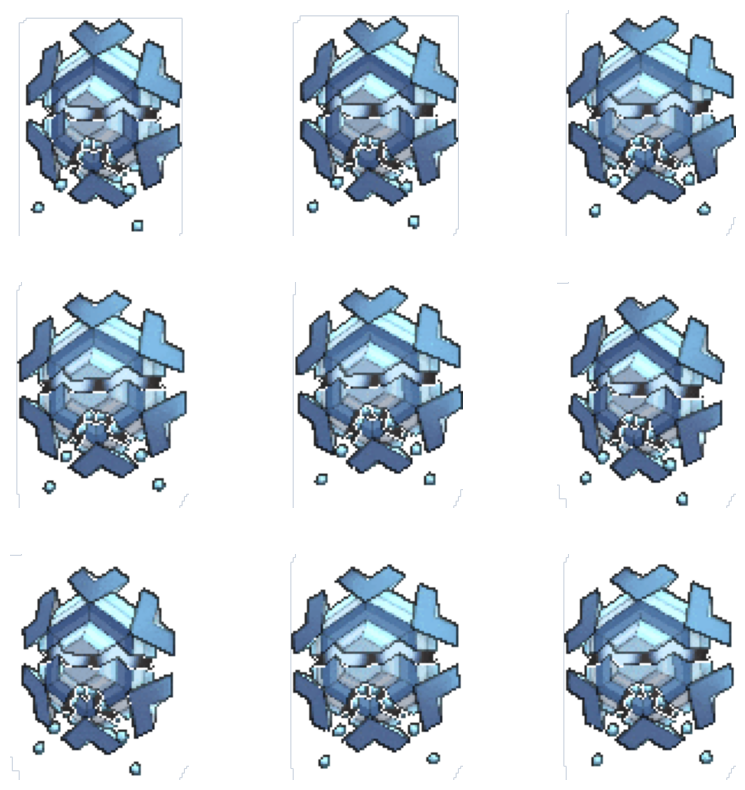

In [5]:
# Display a few images
if image_files:
    plt.figure(figsize=(10, 10))

    for i, img_path in enumerate(image_files[2000:2009]):  # Display the first 9 images
        img = Image.open(img_path)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

In [6]:
image_size = 64
batch_size = 128
latent_size=128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
def apply_transforms(images_array, transform):
  transformed_images=[]
  for img in images_array:
    img=Image.fromarray(img)
    transformed_img=transform(img)
    transformed_images.append(transformed_img)

  transformed_images=torch.stack(transformed_images)
  return transformed_images

In [8]:
len(image_files)

40597

In [9]:
images=[]

for i in range(len(image_files)):
  img=cv2.resize(cv2.imread((image_files[i])), (image_size,image_size))
  images.append(img)

images=np.array(images)
images.shape

(40597, 64, 64, 3)

In [ ]:
all_transforms=T.Compose([
    T.ToTensor(),
    ])

train_ds=apply_transforms(images, all_transforms)

train_dl=DataLoader(train_ds, batch_size, shuffle=True)

In [ ]:
print(len(train_dl))

318


In [ ]:
generator=nn.Sequential(

    nn.ConvTranspose2d(latent_size,512,kernel_size=4,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()
)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

torch.Size([128, 3, 64, 64])


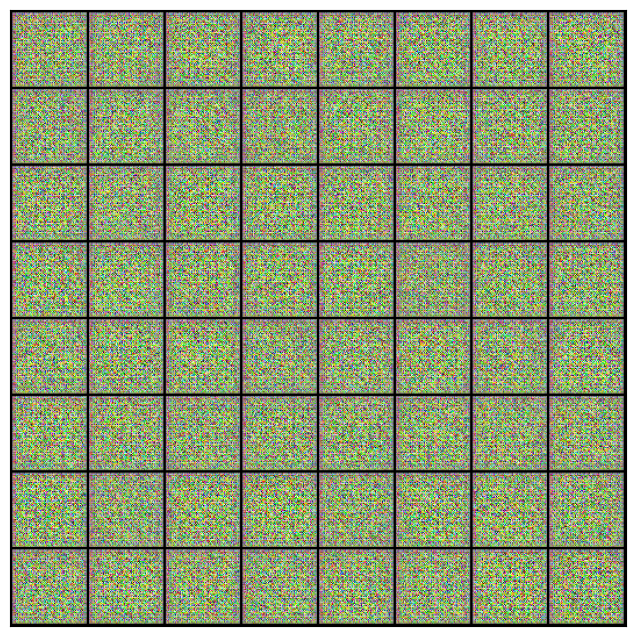

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
discriminator=nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, bias=False),

    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
def train_discriminator(real_images,d):
  d.zero_grad()

  real_preds=discriminator(real_images)
  real_targets=torch.ones(real_images.size(0), 1)
  real_loss=F.binary_cross_entropy(real_preds, real_targets)
  real_score=torch.mean(real_preds).item()

  latent=torch.randn(batch_size, latent_size, 1, 1)
  fake_images=generator(latent)

  fake_targets=torch.zeros(fake_images.size(0), 1)
  fake_preds=discriminator(fake_images)
  fake_loss=F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score=torch.mean(fake_preds).item()

  loss=real_loss+fake_loss
  loss.backward()
  d.step()
  return loss.item(), real_score, fake_score

In [ ]:
def train_generator(g):
  g.zero_grad()

  latent=torch.randn(batch_size, latent_size, 1, 1)
  fake_images=generator(latent)

  preds=discriminator(fake_images)
  targets=torch.ones(batch_size, 1)
  loss=F.binary_cross_entropy(preds, targets)

  loss.backward()
  g.step()

  return loss.item()

In [ ]:
def fit(epochs, lr, start_idx=1):

  losses_g=[]
  losses_d=[]
  real_scores=[]
  fake_scores=[]

  opt_d=torch.optim.Adam(discriminator.parameters(), lr=lr, betas=[0.5, 0.999])
  opt_g=torch.optim.Adam(generator.parameters(), lr=lr, betas=[0.5, 0.999])

  for epoch in range(epochs):
    for real_images in tqdm(train_dl):
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      loss_g=train_generator(opt_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

  return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 5

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
history = fit(2, lr)

  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 2.6957, loss_d: 0.5288, real_score: 0.7770, fake_score: 0.2078


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 1.9362, loss_d: 0.6185, real_score: 0.6031, fake_score: 0.0459


  0%|          | 0/318 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 1.3078, loss_d: 0.5673, real_score: 0.6286, fake_score: 0.0452


  0%|          | 0/318 [00:00<?, ?it/s]

KeyboardInterrupt: 

Saving generated-images-0000.png


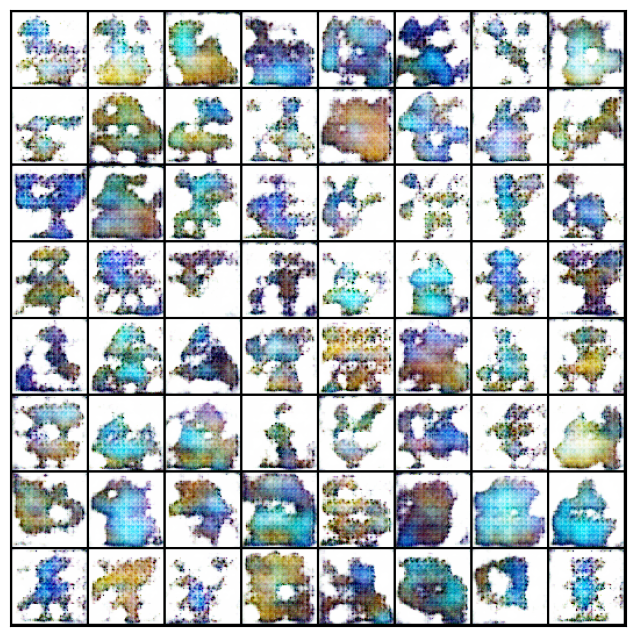

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1)
save_samples(0, fixed_latent)